


<p style="font-size:36px;text-align:center"> <b> Cancer diagnosis</b> </p>

<h2> Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>



<h4> Problem statement : </h4>
<p> Classify the provided genetic variations/mutations using data from text-based medical literature. </p>

<h1>Exploratory Data Analysis</h1>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,log_loss

import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import nltk
nltk.download("stopwords")
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramkiranmeduri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Reading Data</h2>

<h3>Reading Gene and Variation Data</h3>

In [4]:
data = pd.read_csv('/Users/ramkiranmeduri/Desktop/training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head(10)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>Reading Text Data</h3>

In [5]:
# note the seprator in this file
data_text =pd.read_csv("/Users/ramkiranmeduri/Desktop/training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head(10)

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


<h3>Preprocessing of text</h3>

In [6]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_pre_processing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [7]:
#text processing stage.
start_time = time.perf_counter()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_pre_processing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 20.339649166999152 seconds


In [8]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [11]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>Test, Train and Cross Validation Split</h3>

<h4>Splitting data into train, test and cross validation (64:20:16)</h4>

In [12]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

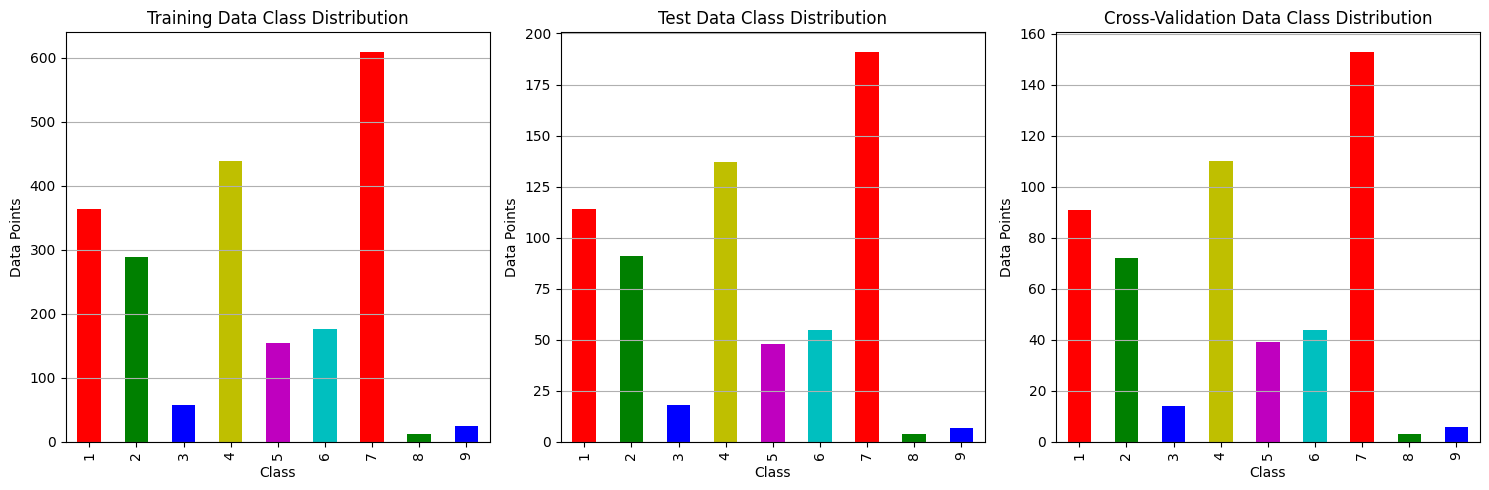

Class distribution in Training Set:
Class 7: 609 (28.672%)
Class 4: 439 (20.669%)
Class 1: 363 (17.09%)
Class 2: 289 (13.606%)
Class 6: 176 (8.286%)
Class 5: 155 (7.298%)
Class 3: 57 (2.684%)
Class 9: 24 (1.13%)
Class 8: 12 (0.565%)
--------------------------------------------------------------------------------
Class distribution in Test Set:
Class 7: 191 (28.722%)
Class 4: 137 (20.602%)
Class 1: 114 (17.143%)
Class 2: 91 (13.684%)
Class 6: 55 (8.271%)
Class 5: 48 (7.218%)
Class 3: 18 (2.707%)
Class 9: 7 (1.053%)
Class 8: 4 (0.602%)
--------------------------------------------------------------------------------
Class distribution in Cross-Validation Set:
Class 7: 153 (28.759%)
Class 4: 110 (20.677%)
Class 1: 91 (17.105%)
Class 2: 72 (13.534%)
Class 6: 44 (8.271%)
Class 5: 39 (7.331%)
Class 3: 14 (2.632%)
Class 9: 6 (1.128%)
Class 8: 3 (0.564%)
--------------------------------------------------------------------------------


In [14]:
# Calculate class distributions
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

# Plot class distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
train_class_distribution.plot(kind='bar', color=['r', 'g', 'b', 'y', 'm', 'c'])
plt.xlabel('Class')
plt.ylabel('Data Points')
plt.title('Training Data Class Distribution')
plt.grid(axis='y')

plt.subplot(1, 3, 2)
test_class_distribution.plot(kind='bar', color=['r', 'g', 'b', 'y', 'm', 'c'])
plt.xlabel('Class')
plt.ylabel('Data Points')
plt.title('Test Data Class Distribution')
plt.grid(axis='y')

plt.subplot(1, 3, 3)
cv_class_distribution.plot(kind='bar', color=['r', 'g', 'b', 'y', 'm', 'c'])
plt.xlabel('Class')
plt.ylabel('Data Points')
plt.title('Cross-Validation Data Class Distribution')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Print class distribution details
def print_class_distribution(distribution, dataset_name):
    sorted_yi = np.argsort(-distribution.values)
    print(f"Class distribution in {dataset_name}:")
    for i in sorted_yi:
        print(f"Class {distribution.index[i]}: {distribution.values[i]} "
              f"({np.round((distribution.values[i] / distribution.sum()) * 100, 3)}%)")
    print('-' * 80)

print_class_distribution(train_class_distribution, 'Training Set')
print_class_distribution(test_class_distribution, 'Test Set')
print_class_distribution(cv_class_distribution, 'Cross-Validation Set')

<h2>Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

Log loss on Cross Validation Data using Random Model 2.4895787301536796
Log loss on Test Data using Random Model 2.4855642150194357
-------------------- Confusion Matrix --------------------


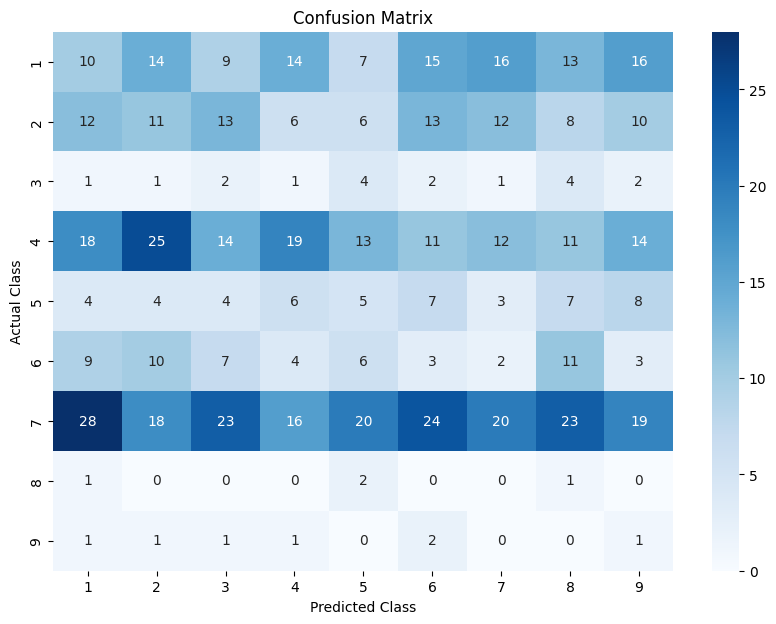

-------------------- Precision Matrix (Column Sum = 1) --------------------


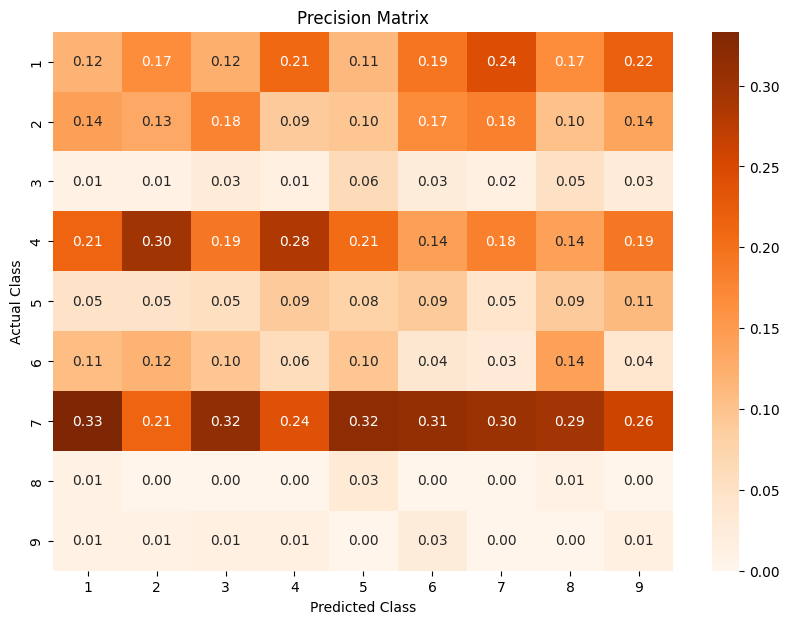

-------------------- Recall Matrix (Row Sum = 1) --------------------


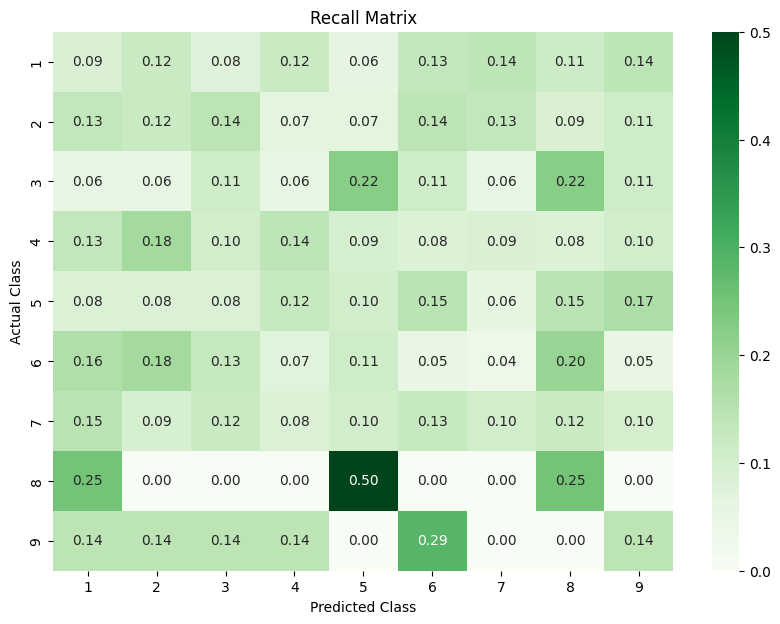

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y, labels):
    C = confusion_matrix(test_y, predict_y)
    # C = 9x9 matrix, each cell (i,j) represents the number of points of class i predicted as class j
    
    A = ((C.T) / C.sum(axis=1)).T
    # A is the recall matrix, where each element is divided by the sum of its row
    B = C / C.sum(axis=0)
    # B is the precision matrix, where each element is divided by the sum of its column

    # Plotting Confusion Matrix
    print("-" * 20, "Confusion Matrix", "-" * 20)
    plt.figure(figsize=(10, 7))
    sns.heatmap(C, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix')
    plt.show()

    # Plotting Precision Matrix
    print("-" * 20, "Precision Matrix (Column Sum = 1)", "-" * 20)
    plt.figure(figsize=(10, 7))
    sns.heatmap(B, annot=True, cmap="Oranges", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Precision Matrix')
    plt.show()

    # Plotting Recall Matrix
    print("-" * 20, "Recall Matrix (Row Sum = 1)", "-" * 20)
    plt.figure(figsize=(10, 7))
    sns.heatmap(A, annot=True, cmap="Greens", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Recall Matrix')
    plt.show()

# Assuming you have test_df, cv_df, y_test, y_cv
# Generate predictions with random probabilities
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# Creating output arrays with random probabilities
cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = (rand_probs / np.sum(rand_probs))

print("Log loss on Cross Validation Data using Random Model",
      log_loss(y_cv, cv_predicted_y))

test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = (rand_probs / np.sum(rand_probs))

print("Log loss on Test Data using Random Model",
      log_loss(y_test, test_predicted_y))

# Convert probabilistic predictions to discrete class predictions
predicted_y = np.argmax(test_predicted_y, axis=1) + 1

# Define class labels
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Plot confusion matrices
plot_confusion_matrix(y_test, predicted_y, labels)

<h2>Univariate Analysis</h2>

In [16]:

def get_gv_fea_dict(alpha, feature, df):
   
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
      

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

<h3>Univariate Analysis on Gene Feature</h3>

In [17]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 231
Gene
BRCA1     169
TP53      104
EGFR       88
BRCA2      86
PTEN       84
BRAF       64
KIT        59
ERBB2      44
ALK        41
PDGFRA     39
Name: count, dtype: int64


In [18]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 231 different categories of genes in the train data, and they are distibuted as follows


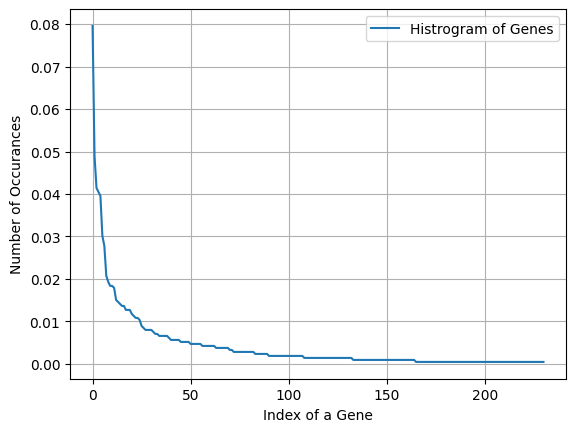

In [19]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


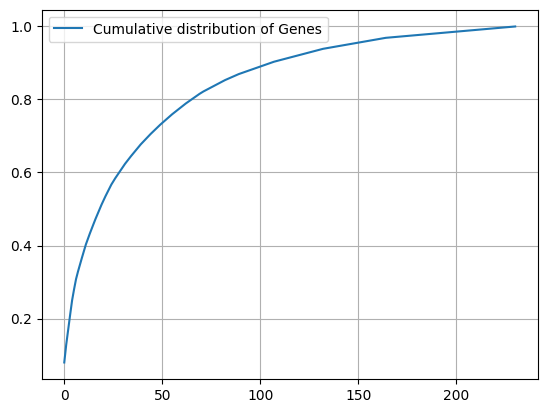

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [22]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [23]:
train_df['Gene'].head()

2760      BRAF
1993    MAP2K1
2699      BRAF
2949       KDR
2960       KIT
Name: Gene, dtype: object

In [24]:
# Assuming gene_vectorizer is an instance of CountVectorizer
feature_names = gene_vectorizer.get_feature_names_out()
print(feature_names)

['abl1' 'acvr1' 'ago2' 'akt1' 'akt2' 'akt3' 'alk' 'apc' 'ar' 'araf'
 'arid1b' 'arid5b' 'atm' 'atr' 'atrx' 'aurka' 'axl' 'b2m' 'bap1' 'bcl10'
 'bcl2' 'bcl2l11' 'bcor' 'braf' 'brca1' 'brca2' 'brip1' 'btk' 'card11'
 'carm1' 'casp8' 'cbl' 'ccnd1' 'ccnd2' 'ccnd3' 'ccne1' 'cdh1' 'cdk12'
 'cdk6' 'cdkn1a' 'cdkn1b' 'cdkn2a' 'cdkn2b' 'cebpa' 'chek2' 'cic' 'crebbp'
 'ctcf' 'ctla4' 'ctnnb1' 'ddr2' 'dicer1' 'dnmt3a' 'dnmt3b' 'dusp4' 'egfr'
 'eif1ax' 'elf3' 'ep300' 'epas1' 'erbb2' 'erbb3' 'erbb4' 'ercc2' 'ercc3'
 'ercc4' 'erg' 'esr1' 'etv1' 'etv6' 'ewsr1' 'ezh2' 'fanca' 'fancc' 'fat1'
 'fbxw7' 'fgf19' 'fgf3' 'fgf4' 'fgfr1' 'fgfr2' 'fgfr3' 'fgfr4' 'flt1'
 'flt3' 'foxa1' 'foxl2' 'foxo1' 'foxp1' 'gata3' 'gli1' 'gna11' 'gnaq'
 'gnas' 'h3f3a' 'hist1h1c' 'hla' 'hnf1a' 'hras' 'idh1' 'idh2' 'igf1r'
 'ikzf1' 'il7r' 'jak1' 'jak2' 'kdm5a' 'kdm5c' 'kdm6a' 'kdr' 'keap1' 'kit'
 'klf4' 'kmt2a' 'kmt2b' 'kmt2c' 'kmt2d' 'knstrn' 'kras' 'lats1' 'lats2'
 'map2k1' 'map2k2' 'map2k4' 'map3k1' 'mapk1' 'mdm2' 'mdm4' 'med12'

For alpha =  1e-05 Log loss: 1.1811096405085826
For alpha =  0.0001 Log loss: 1.1634949997146253
For alpha =  0.001 Log loss: 1.2232488719993015
For alpha =  0.01 Log loss: 1.3728589953944426
For alpha =  0.1 Log loss: 1.4812208267989928
For alpha =  1 Log loss: 1.518544938785446


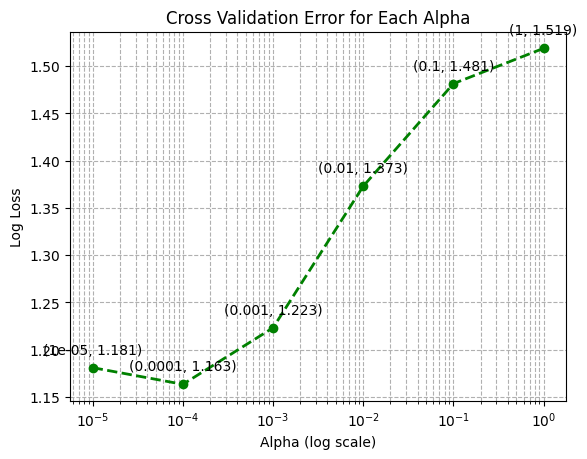

Train Log Loss with best alpha = 0.0001 : 0.9784652768675394
CV Log Loss with best alpha = 0.0001 : 1.1634949997146253
Test Log Loss with best alpha = 0.0001 : 1.249874682453196


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# Sample data: replace with your actual data
# train_gene_feature_onehotCoding, y_train, cv_gene_feature_onehotCoding, y_cv, test_gene_feature_onehotCoding, y_test

# Define alpha values to test
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For alpha = ', i, "Log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

# Plotting the cross-validation log loss for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], txt), (alpha[i], cv_log_error_array[i]), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_xscale('log')
ax.grid(True, which="both", ls="--")
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Log Loss")
plt.show()

# Finding the best alpha with the minimum log loss
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

# Train the model with the best alpha
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

# Calculating and printing log loss for train, cross-validation, and test sets
train_predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('Train Log Loss with best alpha =', best_alpha, ":", log_loss(y_train, train_predict_y, labels=clf.classes_))
cv_predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('CV Log Loss with best alpha =', best_alpha, ":", log_loss(y_cv, cv_predict_y, labels=clf.classes_))
test_predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('Test Log Loss with best alpha =', best_alpha, ":", log_loss(y_test, test_predict_y, labels=clf.classes_))


<h3>Univariate Analysis on Variation Feature</h3>

In [26]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1931
Variation
Truncating Mutations    57
Deletion                46
Amplification           44
Fusions                 20
Overexpression           5
Q61R                     3
T58I                     3
E17K                     3
Q22K                     2
I31M                     2
Name: count, dtype: int64


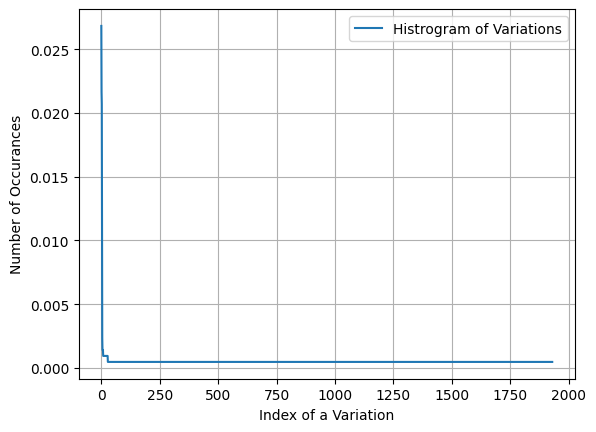

In [27]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.04849341 0.06920904 ... 0.99905838 0.99952919 1.        ]


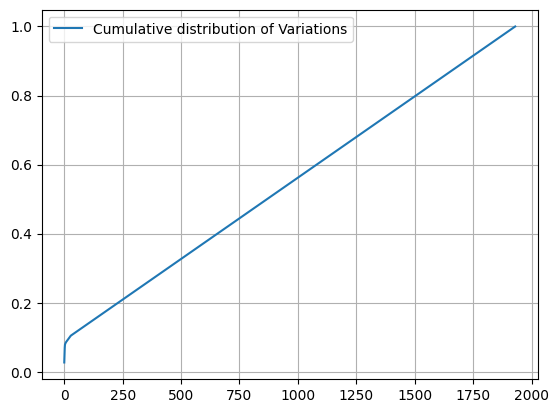

In [28]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [29]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [30]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For alpha = 1e-05 Log loss: 1.6971429487691596
For alpha = 0.0001 Log loss: 1.6877686417744924
For alpha = 0.001 Log loss: 1.6939576229795312
For alpha = 0.01 Log loss: 1.7038010749066912
For alpha = 0.1 Log loss: 1.7128818951442064
For alpha = 1 Log loss: 1.7166158914062493


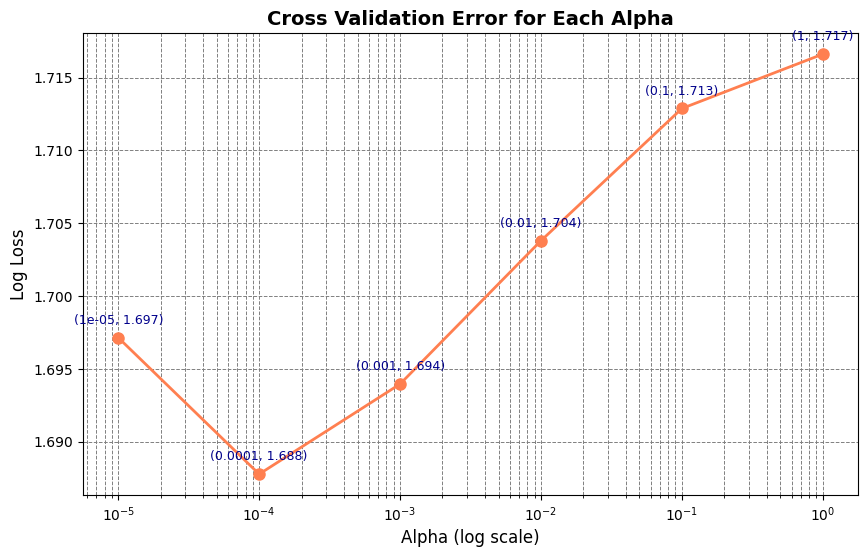

Train Log Loss with best alpha = 0.0001 : 0.7462077295180893
CV Log Loss with best alpha = 0.0001 : 1.6877686417744924
Test Log Loss with best alpha = 0.0001 : 1.6813151789885856


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# Define alpha values to test
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For alpha =', i, "Log loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

# Plotting the cross-validation log loss for each alpha
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(alpha, cv_log_error_array, color='coral', marker='o', linestyle='-', linewidth=2, markersize=8)
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(f'({alpha[i]}, {txt:.3f})', (alpha[i], cv_log_error_array[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='darkblue')

ax.set_xscale('log')
ax.grid(True, which="both", linestyle='--', linewidth=0.7, color='gray')
plt.title("Cross Validation Error for Each Alpha", fontsize=14, fontweight='bold')
plt.xlabel("Alpha (log scale)", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Find the best alpha
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

# Train the model with the best alpha
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

# Calculate and print log loss for train, cross-validation, and test sets
train_predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('Train Log Loss with best alpha =', best_alpha, ":", log_loss(y_train, train_predict_y, labels=clf.classes_))
cv_predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('CV Log Loss with best alpha =', best_alpha, ":", log_loss(y_cv, cv_predict_y, labels=clf.classes_))
test_predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('Test Log Loss with best alpha =', best_alpha, ":", log_loss(y_test, test_predict_y, labels=clf.classes_))


<h3>Univariate Analysis on Text Feature</h3>

In [32]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [33]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# Building a CountVectorizer with all the words that occurred a minimum of 3 times in the train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names_out()

# Summing up occurrences of each word
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# Creating a dictionary with words and their counts
text_fea_dict = dict(zip(train_text_features, train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))


Total number of unique words in train data: 52322


In [35]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [36]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [37]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [38]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [39]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [40]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 4466, 4: 3929, 5: 3105, 6: 2835, 9: 1798, 8: 1686, 7: 1594, 12: 1563, 11: 1346, 10: 1330, 13: 1125, 14: 942, 16: 771, 18: 753, 15: 706, 20: 615, 21: 595, 17: 560, 24: 494, 22: 466, 28: 455, 19: 449, 27: 403, 26: 401, 32: 351, 23: 346, 30: 335, 48: 320, 45: 320, 25: 316, 33: 304, 36: 286, 29: 279, 31: 261, 40: 237, 41: 226, 39: 220, 42: 217, 34: 210, 35: 193, 44: 187, 51: 185, 52: 181, 37: 176, 38: 167, 46: 166, 50: 164, 54: 156, 55: 146, 56: 145, 43: 143, 49: 141, 53: 138, 60: 127, 47: 126, 57: 123, 66: 121, 72: 117, 67: 115, 59: 114, 70: 112, 64: 108, 63: 106, 61: 105, 65: 103, 62: 103, 58: 103, 82: 96, 96: 93, 69: 92, 81: 90, 73: 85, 68: 83, 100: 82, 71: 81, 83: 79, 80: 77, 74: 77, 90: 76, 84: 76, 87: 74, 75: 72, 91: 68, 77: 68, 85: 67, 92: 66, 88: 66, 86: 64, 78: 64, 76: 64, 95: 63, 79: 62, 104: 60, 89: 60, 108: 59, 97: 58, 93: 58, 110: 54, 101: 54, 126: 52, 105: 52, 109: 51, 94: 51, 144: 50, 107: 49, 119: 48, 118: 48, 114: 48, 129: 47, 98: 47, 132: 46, 106: 46, 102: 46,

Total number of unique words in train data: 52322
For values of alpha = 1e-05 The log loss is: 1.889744416152233
For values of alpha = 0.0001 The log loss is: 1.891646338956518
For values of alpha = 0.001 The log loss is: 1.8891800402874848
For values of alpha = 0.01 The log loss is: 1.881517872471457
For values of alpha = 0.1 The log loss is: 1.8744585145396429
For values of alpha = 1 The log loss is: 1.8995687103052101


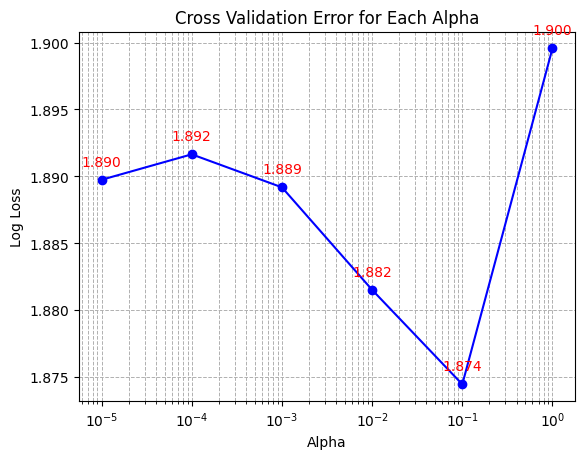

For values of best alpha = 0.1 The train log loss is: 0.88206278286325
For values of best alpha = 0.1 The cross validation log loss is: 1.8744585145396429
For values of best alpha = 0.1 The test log loss is: 1.8772349106913782


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

# Building a CountVectorizer with all the words that occurred a minimum of 3 times in the train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names_out()

# Summing up occurrences of each word
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# Creating a dictionary with words and their counts
text_fea_dict = dict(zip(train_text_features, train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

# Hyperparameter tuning for SGDClassifier
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha =', i, "The log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))

# Plotting the results
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, marker='o', linestyle='-', color='b')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(f'{txt:.3f}', (alpha[i], cv_log_error_array[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha")
plt.ylabel("Log Loss")
plt.show()

# Fit the best model
best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y_train = sig_clf.predict_proba(train_text_feature_onehotCoding)
predict_y_cv = sig_clf.predict_proba(cv_text_feature_onehotCoding)
predict_y_test = sig_clf.predict_proba(test_text_feature_onehotCoding)

print('For values of best alpha =', best_alpha, "The train log loss is:", log_loss(y_train, predict_y_train, labels=clf.classes_))
print('For values of best alpha =', best_alpha, "The cross validation log loss is:", log_loss(y_cv, predict_y_cv, labels=clf.classes_))
print('For values of best alpha =', best_alpha, "The test log loss is:", log_loss(y_test, predict_y_test, labels=clf.classes_))


In [42]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

def get_intersec_text(df):
    # Vectorize text data with minimum document frequency of 3
    text_vectorizer = CountVectorizer(min_df=3)
    df_text_fea = text_vectorizer.fit_transform(df['TEXT'])
    
    # Getting all the feature names (words)
    df_text_features = text_vectorizer.get_feature_names_out()
    
    # Summing up occurrences of each word
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    
    # Creating a dictionary with words and their counts
    df_text_fea_dict = dict(zip(df_text_features, df_text_fea_counts))
    
    # Find intersection with train text features
    train_text_features = text_vectorizer.get_feature_names_out()
    
    # Calculate intersection
    intersect_words = set(df_text_features).intersection(set(train_text_features))
    
    len1 = len(df_text_features)
    len2 = len(intersect_words)
    
    return len1, len2

# Apply function and print results
len1, len2 = get_intersec_text(test_df)
print(np.round((len2 / len1) * 100, 3), "% of words in test data appeared in train data")

len1, len2 = get_intersec_text(cv_df)
print(np.round((len2 / len1) * 100, 3), "% of words in cross-validation data appeared in train data")


100.0 % of words in test data appeared in train data
100.0 % of words in cross-validation data appeared in train data


<h1>Ensemble Models</h1>

In [44]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [45]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [46]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px> <b>Stacking the three types of features </b><p>

In [47]:


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [48]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54516)
(number of data points * number of features) in test data =  (665, 54516)
(number of data points * number of features) in cross validation data = (532, 54516)


In [49]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>Random Forest Classifier</h2>

<h3>Hyper paramter tuning (With One hot Encoding)</h3>

For n_estimators = 100 and max_depth = 5
Log Loss: 2.042136334013561
For n_estimators = 100 and max_depth = 10
Log Loss: 2.010300030629125
For n_estimators = 200 and max_depth = 5
Log Loss: 2.0402525846953927
For n_estimators = 200 and max_depth = 10
Log Loss: 2.0215751100607307
For n_estimators = 500 and max_depth = 5
Log Loss: 2.0642905061644985
For n_estimators = 500 and max_depth = 10
Log Loss: 2.008527366117461
For n_estimators = 1000 and max_depth = 5
Log Loss: 2.0604096745159985
For n_estimators = 1000 and max_depth = 10
Log Loss: 2.003132704952187
For n_estimators = 2000 and max_depth = 5
Log Loss: 2.063386046704813
For n_estimators = 2000 and max_depth = 10
Log Loss: 1.9999875830233729


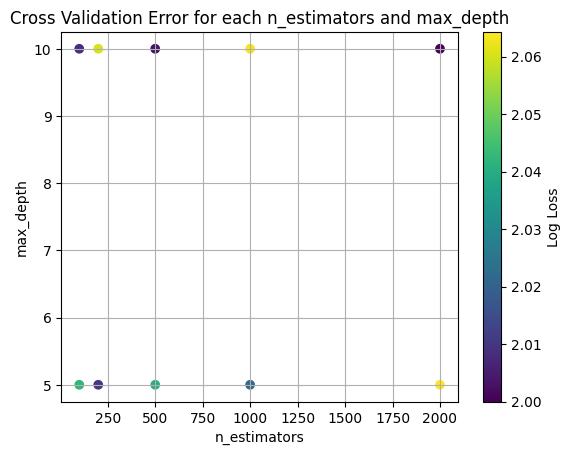

For values of best n_estimators = 2000 The train log loss is: 0.6792338171533059
For values of best n_estimators = 2000 The cross validation log loss is: 1.9999875830233729
For values of best n_estimators = 2000 The test log loss is: 2.0039483873293813


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

alpha = [100, 200, 500, 1000, 2000]
max_depth = [5, 10]
cv_log_error_array = []

# Iterate over hyperparameters
for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i, "and max_depth =", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss:", log_loss(cv_y, sig_clf_probs))

# Plotting
fig, ax = plt.subplots()
# Create a grid for plotting
alpha_grid, max_depth_grid = np.meshgrid(alpha, max_depth)
alpha_flat = alpha_grid.ravel()
max_depth_flat = max_depth_grid.ravel()
cv_log_error_array = np.array(cv_log_error_array)

# Scatter plot of log loss with hyperparameters
sc = ax.scatter(alpha_flat, max_depth_flat, c=cv_log_error_array, cmap='viridis', marker='o')
plt.colorbar(sc, ax=ax, label='Log Loss')
plt.grid()
plt.title("Cross Validation Error for each n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

# Finding the best parameters
best_index = np.argmin(cv_log_error_array)
best_n_estimators = alpha_flat[best_index]
best_max_depth = max_depth_flat[best_index]

# Train and evaluate with best parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best n_estimators =', best_n_estimators, "The train log loss is:", log_loss(train_y, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best n_estimators =', best_n_estimators, "The cross validation log loss is:", log_loss(cv_y, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best n_estimators =', best_n_estimators, "The test log loss is:", log_loss(y_test, predict_y))


<h3>Testing model with best hyper parameters (One Hot Encoding)</h3>

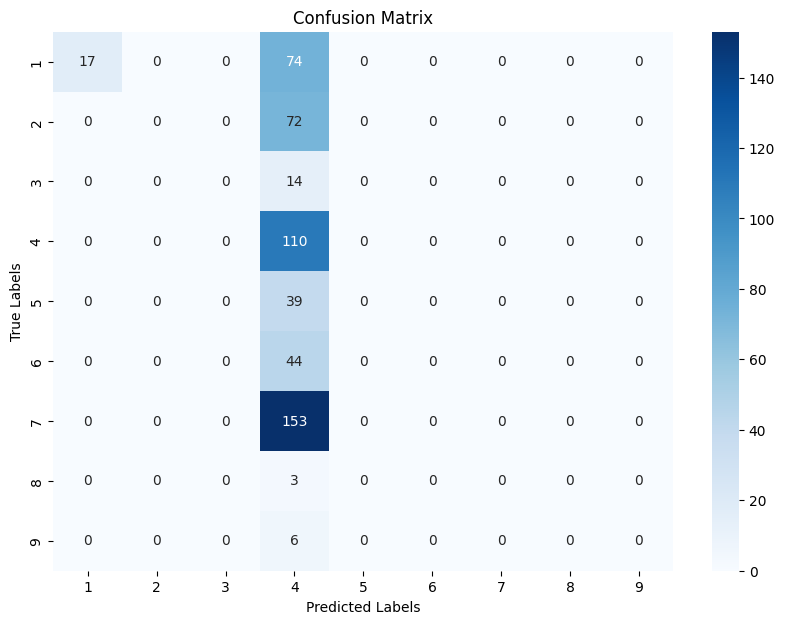

Number of misclassified points: 0.7612781954887218


In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    pred_y = clf.predict(test_x)
    
    # Compute confusion matrix
    cm = confusion_matrix(test_y, pred_y, labels=clf.classes_)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, labels=clf.classes_)
    
    # Calculate the number of misclassified points
    misclassified_count = np.count_nonzero(pred_y != test_y) / test_y.shape[0]
    print("Number of misclassified points:", misclassified_count)

# Usage
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

def get_impfeature_names(indices, text, gene, var, no_features):
    # Vectorize features
    text_count_vec = CountVectorizer(min_df=3)
    text_vec = text_count_vec.fit_transform(train_df['TEXT'])
    
    gene_vec = CountVectorizer(min_df=3)
    gene_vec.fit(train_df['Gene'])
    
    var_count_vec = CountVectorizer(min_df=3)
    var_vec = var_count_vec.fit(train_df['Variation'])
    
    # Get feature names
    text_features = text_count_vec.get_feature_names_out()
    gene_features = gene_vec.get_feature_names_out()
    var_features = var_count_vec.get_feature_names_out()
    
    print(f"Text Features Length: {len(text_features)}")
    print(f"Gene Features Length: {len(gene_features)}")
    print(f"Variation Features Length: {len(var_features)}")
    
    # Display important features
    print("Top Features:")
    for i in indices:
        if i < len(text_features):
            print(f"Text Feature: {text_features[i]}")
        elif i < len(text_features) + len(gene_features):
            print(f"Gene Feature: {gene_features[i - len(text_features)]}")
        elif i < len(text_features) + len(gene_features) + len(var_features):
            print(f"Variation Feature: {var_features[i - len(text_features) - len(gene_features)]}")

# Example Usage
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-" * 50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index], test_df['Gene'].iloc[test_point_index], test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class: 4
Predicted Class Probabilities: [[0.2785 0.1313 0.0276 0.3341 0.0736 0.0522 0.0881 0.007  0.0076]]
Actual Class: 7
--------------------------------------------------
Text Features Length: 52322
Gene Features Length: 134
Variation Features Length: 26
Top Features:
Text Feature: m135t
Text Feature: phenylmethylsulphonylfluoride
Text Feature: synthetase
Text Feature: functioning
Text Feature: e7x
Text Feature: noncanccrous
Text Feature: mg132
Text Feature: h3k36me3
Text Feature: l118
Text Feature: thymocytes21
Text Feature: snapfrozen
Text Feature: hypotension
Text Feature: k23
Text Feature: deregulation
Text Feature: cysteinyl
Text Feature: therapy3
Text Feature: vivo44
Text Feature: gau
Text Feature: gfpt2
Text Feature: upgrading
Text Feature: 1n8z
Text Feature: cova
Text Feature: ser98
Text Feature: transported
Text Feature: preliminary
Text Feature: m1411t
Text Feature: ibaraki
Text Feature: gelatin
Text Feature: y780
Text Feature: ssgsea
Text Feature: bellomo
Text F

<h4>Inorrectly Classified point</h4>

In [53]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2785 0.1313 0.0275 0.3342 0.0736 0.0522 0.0881 0.007  0.0076]]
Actuall Class : 1
--------------------------------------------------
Text Features Length: 52322
Gene Features Length: 134
Variation Features Length: 26
Top Features:
Text Feature: m135t
Text Feature: phenylmethylsulphonylfluoride
Text Feature: synthetase
Text Feature: functioning
Text Feature: e7x
Text Feature: noncanccrous
Text Feature: mg132
Text Feature: h3k36me3
Text Feature: l118
Text Feature: thymocytes21
Text Feature: snapfrozen
Text Feature: hypotension
Text Feature: k23
Text Feature: deregulation
Text Feature: cysteinyl
Text Feature: therapy3
Text Feature: vivo44
Text Feature: gau
Text Feature: gfpt2
Text Feature: upgrading
Text Feature: 1n8z
Text Feature: cova
Text Feature: ser98
Text Feature: transported
Text Feature: preliminary
Text Feature: m1411t
Text Feature: ibaraki
Text Feature: gelatin
Text Feature: y780
Text Feature: ssgsea
Text Feature: bellomo
Tex

<h3>Hyper paramter tuning (With Response Coding)</h3>

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np

alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i, "and max depth =", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss:", log_loss(cv_y, sig_clf_probs))

# Identify the best parameters
best_alpha = np.argmin(cv_log_error_array)
best_n_estimators = alpha[int(best_alpha / len(max_depth))]
best_max_depth = max_depth[int(best_alpha % len(max_depth))]

clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Evaluate performance
predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best n_estimators =', best_n_estimators, "The train log loss is:", log_loss(train_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best n_estimators =', best_n_estimators, "The cross validation log loss is:", log_loss(cv_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best n_estimators =', best_n_estimators, "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))


for n_estimators = 10 and max depth = 2
Log Loss: 2.1344425557831674
for n_estimators = 10 and max depth = 3
Log Loss: 1.7025021817189092
for n_estimators = 10 and max depth = 5
Log Loss: 1.4443603666260367
for n_estimators = 10 and max depth = 10
Log Loss: 1.8228558274065016
for n_estimators = 50 and max depth = 2
Log Loss: 1.6582066412353447
for n_estimators = 50 and max depth = 3
Log Loss: 1.4229400272223622
for n_estimators = 50 and max depth = 5
Log Loss: 1.3712900648288773
for n_estimators = 50 and max depth = 10
Log Loss: 1.6482932192704394
for n_estimators = 100 and max depth = 2
Log Loss: 1.5292782295858809
for n_estimators = 100 and max depth = 3
Log Loss: 1.4350748296215818
for n_estimators = 100 and max depth = 5
Log Loss: 1.3277646617357146
for n_estimators = 100 and max depth = 10
Log Loss: 1.637376198684531
for n_estimators = 200 and max depth = 2
Log Loss: 1.5490830441375891
for n_estimators = 200 and max depth = 3
Log Loss: 1.4537690814348134
for n_estimators = 200 and

<h3>Testing model with best hyper parameters (Response Coding)</h3>

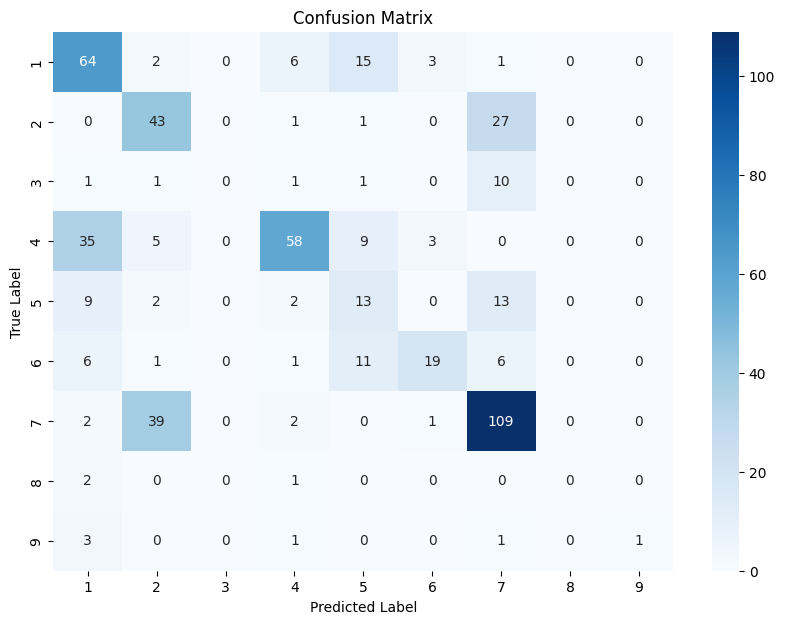

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    pred_y = clf.predict(test_x)

    # Compute confusion matrix
    cm = confusion_matrix(test_y, pred_y)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    plt.show()

# Use 'sqrt' for max_features
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha % len(max_depth))],
                             n_estimators=alpha[int(best_alpha / len(max_depth))],
                             criterion='gini',
                             max_features='sqrt',  # Updated parameter
                             random_state=42)

predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)


<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [56]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0398 0.1581 0.2636 0.0488 0.0478 0.0622 0.1079 0.1535 0.1182]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h4>4.5.5.2. Incorrectly Classified point</h4>

In [57]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.205  0.1234 0.1795 0.1916 0.0349 0.0542 0.0172 0.1276 0.0667]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h2>Stack the models </h2>

<h3>testing with hyper parameter tuning</h3>

In [58]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import log_loss

# Initialize classifiers with corrected parameters
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

# Print log loss for each classifier
sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

# Perform stacking with logistic regression as meta-classifier
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[('sgd_log', sig_clf1), ('sgd_hinge', sig_clf2), ('nb', sig_clf3)], final_estimator=lr, passthrough=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifier : for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 1.87
Support vector machines : Log Loss: 1.85
Naive Bayes : Log Loss: 1.32
--------------------------------------------------
Stacking Classifier : for the value of alpha: 0.000100 Log Loss: 2.174
Stacking Classifier : for the value of alpha: 0.001000 Log Loss: 2.155
Stacking Classifier : for the value of alpha: 0.010000 Log Loss: 2.107
Stacking Classifier : for the value of alpha: 0.100000 Log Loss: 2.051
Stacking Classifier : for the value of alpha: 1.000000 Log Loss: 2.048
Stacking Classifier : for the value of alpha: 10.000000 Log Loss: 2.028


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.2490750583854378
Log loss (CV) on the stacking classifier : 2.051036360121043
Log loss (test) on the stacking classifier : 2.0783792348534624
Number of misclassified points: 313


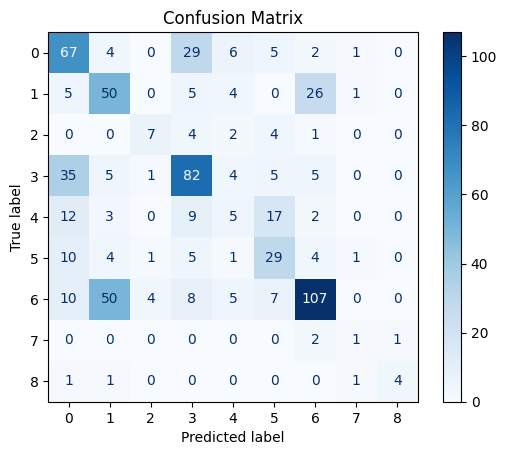

In [59]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Logistic Regression for the meta-classifier
lr = LogisticRegression(C=0.1)

# Initialize the Stacking Classifier with the correct parameters
sclf = StackingClassifier(
    estimators=[('log_reg', sig_clf1), ('svm', sig_clf2), ('nb', sig_clf3)], 
    final_estimator=lr, 
    passthrough=True
)
sclf.fit(train_x_onehotCoding, train_y)

# Evaluate the performance
log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :", log_error)

# Print the number of misclassified points
misclassified_points = np.count_nonzero(sclf.predict(test_x_onehotCoding) != test_y)
print("Number of misclassified points:", misclassified_points)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_y, sclf.predict(test_x_onehotCoding))


<h3>Maximum Voting classifier </h3>

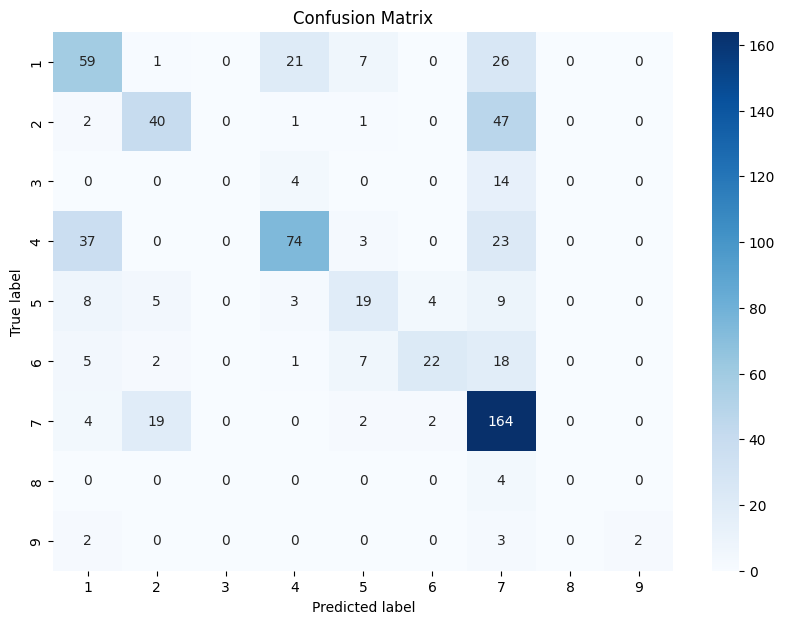

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_static(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
plot_confusion_matrix_static(test_y, y_pred, class_names)
